# ch4

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

SEED=42
np.random.seed(42)

## Linear Regression

[[4.21509616]
 [2.77011339]]


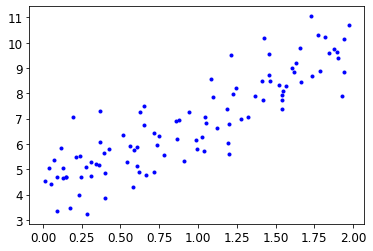

In [2]:
# y = 4+3x +gaussian blur
X = 2*np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)
plt.plot(X,y,".b")

# find theta_hat
X_b = np.c_[np.ones((100,1)),X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print(theta_best)

[[4.21509616]
 [9.75532293]]


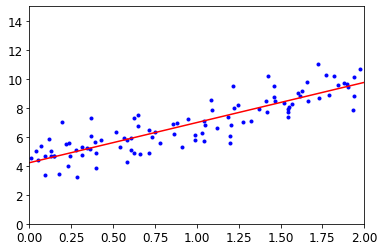

In [3]:
# predict y and line
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_pred = X_new_b.dot(theta_best)
print(y_pred)
plt.axis([0,2,0,15]) # set window??
plt.plot(X,y,"b.")
plt.plot(X_new,y_pred,"r-")

In [4]:
# linear regression with sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

# np.linalg.pinv(X_b).dot(y) # 이렇게도 ㄱㄴ
# https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse#Singular_value_decomposition_(SVD)

[4.21509616] [[2.77011339]]
[[4.21509616]
 [9.75532293]]


## Gradient Descent

In [5]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 1000
theta = np.random.randn(2,1)

for i in range(m+1):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
print(list(theta))


[array([4.15828724]), array([2.82027257])]


stochastic gradient descent

In [6]:
n_epochs = 50
t0,t1 = 5,50
theta = np.random.randn(2,1)

def learning_schedule(t): 
    return t0/(t+t1)

for epoch in range(n_epochs):
    for i in range(m):
        idx = np.random.randint(m)
        xi = X_b[idx:idx+1]
        yi = y[idx:idx+1]
        gradients = 2* xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch*m+i)
        theta = theta - eta * gradients
print(list(theta)) # why answer random??? 3.xxxx

[array([3.58179619]), array([3.33709681])]


In [7]:
# with sklearn
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=100, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())
print(sgd_reg.intercept_, sgd_reg.coef_)

[4.20011322] [2.75690565]


## Polynomial Regression

In [16]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

In [12]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0],X_poly[0])

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[0.7546826] [0.7546826  0.56954582]
[2.16094478] [[0.99975622 0.48439572]]


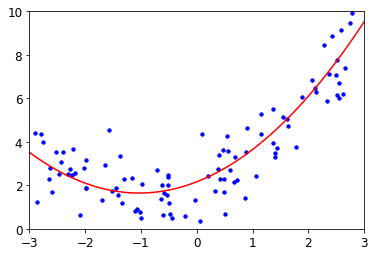

In [40]:
m = 100
plt.axis([-3,3,0,10])
# plt.plot(X_new, y_new, "b.")
plt.plot(X, y, "b.")

# def plot_coef(X,coeffs):
#     degree = len(coeffs)
#     y = np.zeros(len(X))
#     for i in len(degree):
X_new = np.linspace(-3,3,100).reshape(100,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X,y,"b.")
plt.plot(X_new,y_new,"r-")